# Using internet speed and access to measure GDP per capita

***Horace Fung and Shivam Saraogi***

This notebook analyzes the relationship between internet speed and access to GDP per capita. The goal is to use internet speed and access as a proxy to measure GDP. In less developed countries, GDP is often poorly measured due to a lack of proper infrastructure or improper methodology. This is problematic when we compare GDP between countries. Therefore, a model that can circumvent the typical output accounting process may provide GDP <em>comparisons </em> that are more meaningful. The goal is not to get accurate GDP data; the goal is to have standardized data. We chose internet speed and access because of two reasons. Firstly, with technology becoming a key driver of economic growth, we believe that developed countries (with higher GDPs) can afford to and may want to spend more on network infrastructure, whether it is supplied by government or private firms. Secondly, the process of measuring internet speed/access is relatively easier and less prone to error than GDP accounting. 

The notebook is broken into 3 parts:

**1)**   Cleaning the data: We will clean up the data and merge into one dataframe for easier use
<br>
**2)**   Graphing the data: We will produce some graphs to show the relationships between the variables
<br>
**3)**   Creating the regression: Will will create a multiple variable regression to estimate GDP

In [11]:
import sys                            
import pandas as pd                    
import matplotlib.pyplot as plt          
import numpy as np                     
import seaborn.apionly as sns          

# plotly imports (Had to change from go since the graph was not showing up for others)
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot  
from plotly.graph_objs import *
init_notebook_mode()             
import plotly                                
import cufflinks as cf                       
from plotly import tools
cf.set_config_file(offline=True, offline_show_link=False)

# For regression 
import statsmodels.api as sm 

# For 3D plot
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show 
from mpl_toolkits.mplot3d import Axes3D

# To show graphs on notebook
%matplotlib inline             
plotly.offline.init_notebook_mode(connected=True) 

## Part I: Cleaning and examining the data

There are three data sources. Internet speed comes from an [Akamai research](http://www.wikiwand.com/en/List_of_countries_by_Internet_connection_speeds) and internet access comes from [Internet Live Stats](http://www.internetlivestats.com/internet-users-by-country/). The data could be scrapped, but for simplicity, we created excel files on the computer instead (the webpage data does not update, so there is not much benefit to scraping). The data for GDP per capita comes from the [World Economic Outlook](https://www.imf.org/external/pubs/ft/weo/2016/01/weodata/WEOApr2016all.xls) database.

In [16]:
# Importing internet speed/access and WEO data

path = '/Users/horacefung/Desktop/1 Uni/Sophomore/Spring_2016/Data_Bootcamp/Project Data' # Internet speed data
file = '/InternetSpeed.xlsx'
speed = pd.read_excel(path+file)

path = '/Users/horacefung/Desktop/1 Uni/Sophomore/Spring_2016/Data_Bootcamp/Project Data' # Internet access data
file = '/InternetAccess.xlsx'
access = pd.read_excel(path+file)

url = 'https://www.imf.org/external/pubs/ft/weo/2016/01/weodata/WEOApr2016all.xls'       # World Economic Outlook data
weo = pd.read_csv(url, 
                  sep = '\t',
                  skipfooter=1, engine='python',
                  na_values=['n/a', '--'],
                  thousands =',')  

**Quick look at the data**

Looking at the data, we are interested in the **Avg. connection speed (Mb/s)** column in speed and the **Penetration as %Pop column in access**. I want to merge the relevant columns into one dataframe to make graphing simplier.

In [13]:
speed.head()

Country/Territory  Avg. connection speed (Mb/s)  \
0            Global                           5.1   
1         Argentina                           4.2   
2           Bolivia                           1.8   
3            Brazil                           3.6   
4            Canada                          11.9   

   Avg. Peak Connection Speed (Mb/s)  Above 4 Mbit/s  Above 10 Mbit/s  \
0                               32.2           0.650            0.270   
1                               26.9           0.390            0.031   
2                               13.9           0.028            0.002   
3                               29.0           0.320            0.022   
4                               52.4           0.870            0.430   

   Above 15 Mbit/s  
0            0.150  
1            0.005  
2            0.001  
3            0.006  
4            0.210

In [14]:
access.head()

Country  Internet Users  Penetration as %Pop  Population  Non-Users  \
1   China       721434547                0.522  1382323332  660888785   
2   India       462124989                0.348  1326801576  864676587   
3    U.S.       286942362                0.885   324118787   37176425   
4  Brazil       139111185                0.664   209567920   70456735   
5   Japan       115111595                0.911   126323715   11212120   

   Users 1 Year Change (%)  Internet Users 1 YR Change  Population 1 YR Change  
1                    0.022                    15520515                  0.0046  
2                    0.305                   108010242                  0.0120  
3                    0.011                     3229955                  0.0073  
4                    0.051                     6753879                  0.0083  
5                    0.001                      117385                 -0.0020

In [17]:
weo.head()

WEO Country Code  ISO WEO Subject Code      Country  \
0               512  AFG           NGDP_R  Afghanistan   
1               512  AFG        NGDP_RPCH  Afghanistan   
2               512  AFG             NGDP  Afghanistan   
3               512  AFG            NGDPD  Afghanistan   
4               512  AFG           NGDP_D  Afghanistan   

                        Subject Descriptor  \
0  Gross domestic product, constant prices   
1  Gross domestic product, constant prices   
2   Gross domestic product, current prices   
3   Gross domestic product, current prices   
4         Gross domestic product, deflator   

                                       Subject Notes              Units  \
0  Expressed in billions of national currency uni...  National currency   
1  Annual percentages of constant price GDP are y...     Percent change   
2  Expressed in billions of national currency uni...  National currency   
3  Values are based upon GDP in national currency...       U.S. dollars   
4  The GDP deflator is derived by dividing curren...              Index   

      Scale                      Country/Series-specific Notes  1980  \
0  Billions  Source: National Statistics Office Latest actu...   NaN   
1       NaN  See notes for:  Gross domestic product, consta...   NaN   
2  Billions  Source: National Statistics Office Latest actu...   NaN   
3  Billions  See notes for:  Gross domestic product, curren...   NaN   
4       NaN  See notes for:  Gross domestic product, consta...   NaN   

           ...                2013      2014      2015      2016      2017  \
0          ...             457.654   463.520   470.313   479.800   494.431   
1          ...               3.933     1.282     1.466     2.017     3.049   
2          ...            1116.827  1173.182  1174.129  1234.006  1328.672   
3          ...              20.170    20.444    19.204    17.275    17.449   
4          ...             244.033   253.103   249.648   257.192   268.727   

       2018      2019      2020      2021  Estimates Start After  
0   511.815   532.369   553.637   575.622                 2014.0  
1     3.516     4.016     3.995     3.971                 2014.0  
2  1457.509  1606.898  1771.165  1952.397                 2014.0  
3    18.468    19.648    20.905    22.217                 2014.0  
4   284.772   301.839   319.915   339.180                 2014.0  

[5 rows x 52 columns]

**Cleaning up the data**

There are a few things we want to clean up here. Firstly, there should be clearer names for the columns. Secondly, we want to have the access data expressed as a percentage. Thirdly, just by testing with pd.shape, the number of countries are not the same. After sorting these problems out, we can merge everything into a new dataframe.

In [18]:
# Setting speed dataframe to only country and internet speed columns

speed = speed[['Country/Territory', 'Avg. connection speed (Mb/s)']]  # Selecting the two needed columns
Newnames_1 = [['Country', 'Average Connection Speed (Mb/s)']] # Better names
speed.columns = Newnames_1 # Renaming columns
speed = speed.drop(speed.index[[0]])  # Dropping the index 0 row which is global averages.
speed.head()

Country  Average Connection Speed (Mb/s)
1  Argentina                              4.2
2    Bolivia                              1.8
3     Brazil                              3.6
4     Canada                             11.9
5      Chile                              5.7

In [19]:
# Setting access dataframe to only country and access columns

access = access[['Country', 'Penetration as %Pop']]
Newnames_2 = ['Country', '% Internet Penetration'] # Better names
access.columns = Newnames_2
access.loc[:,'% Internet Penetration'] *= 100  # multiply the observations to get the floats in percentage

# Selecting only observations with the same countries as speed

countries_list = speed['Country'].tolist() # create a list of the country names avaliable in speed                         
access_1 = access[access['Country'].isin(countries_list)] # use countries_list to select the same countries for access  
print('Internet Speed observations:', speed.shape, '| Internet Access observations:', access_1.shape) 

Internet Speed observations: (55, 2) | Internet Access observations: (51, 2)


We are missing 4 observations (55 vs 51 countries). This could be due to i) Internet Access does not have data for those countries, ii) the country names are different or iii) a mix of both. We can check with merge.

In [20]:
# Figuring out which countries are missing/named incorrectly

check = pd.merge(speed, access_1, how='outer', indicator=True)
access_missing = check[check['_merge']=='left_only'][speed.columns]
access_missing 

Country  Average Connection Speed (Mb/s)
12   United States                             12.6
27          Taiwan                             10.1
29         Vietnam                              3.4
54  United Kingdom                             13.0

Output shows that these 4 countries were missing from the access dataframe. Upon inspection, United States, Vietnam and United Kingdom have different names. Taiwan is not on the access dataframe and should be left out.

In [21]:
# Correcting the country names

access['Country'] = access['Country'].replace(to_replace=['U.S.', 'Viet Nam', 'U.K.'], 
                                              value=['United States', 'Vietnam', 'United Kingdom'])

In [22]:
# Cleaning up WEO data

weo = weo[['Country', 'WEO Subject Code', '2016']]
subject_variable = ['NGDPDPC'] # GDP per capita, current prices, US dollars currency
weo_2 = weo[weo['WEO Subject Code'].isin(subject_variable) & weo['Country'].isin(countries_list)] 
weo_2 = weo_2.set_index(['Country'])
weo_cleaned = weo_2[['2016']] # Now that we got the correct subject code, we can just drop other years
weo_cleaned.columns = ['GDP per capita in dollars']
weo_cleaned.head()

GDP per capita in dollars
Country                             
Argentina                  10050.973
Australia                  49144.526
Austria                    44777.821
Belgium                    40688.479
Bolivia                     2898.338

In [23]:
# Merging the datasets into one

speed = speed.set_index(['Country'])
access = access.set_index(['Country'])
speed_access = speed.merge(access, left_index=True, right_index=True)
internet = weo_cleaned.merge(speed_access, left_index=True, right_index=True) # Run the line twice to merge both
internet.head()

GDP per capita in dollars  Average Connection Speed (Mb/s)  \
Country                                                                     
China                           8239.894                              3.7   
India                           1747.493                              2.5   
United States                  57220.196                             12.6   
Brazil                          7447.443                              3.6   
Japan                          34870.931                             15.0   

               % Internet Penetration  
Country                                
China                            52.2  
India                            34.8  
United States                    88.5  
Brazil                           66.4  
Japan                            91.1

In [24]:
internet.shape # Double-checking we have the correct number of countries here

(51, 3)

In [25]:
internet.dtypes

GDP per capita in dollars          float64
Average Connection Speed (Mb/s)    float64
% Internet Penetration             float64
dtype: object

# Part II: Graphing the variables

We begin by plotting two horizontal bar charts for speed and access. The charts are designed to give a general overview of how internet speed/access differs across the countries.

In [26]:
# Sorting the data in ascending order

internet_speed_sorted = internet.sort_values('Average Connection Speed (Mb/s)', ascending = True)
internet_access_sorted = internet.sort_values('% Internet Penetration', ascending = True)

In [27]:
# Finding the max/min speed and access values for the graph
# We need this to plot the mean average lines

print(internet_speed_sorted.index[-1], internet_speed_sorted.index[0],
      internet_access_sorted.index[-1], internet_access_sorted.index[0])

Sweden Paraguay Norway Indonesia


**Plotting bar charts**

In [28]:
# Using plotly to create two descending horizontal barcharts for speed and access

# Creating a trace for speed
speed = Bar(
    x=internet_speed_sorted['Average Connection Speed (Mb/s)'],
    y=internet_speed_sorted.index, 
    marker=dict(color='rgb(0, 163, 209)'), # We will be using a blue (speed) and orange (access) color scheme
    name='Internet Speed in the world', # Label
    orientation='h',) # Horizontal bar-chart
    
# Creating a trace for an average speed line 
speed_mean = Scatter(
    x= [internet['Average Connection Speed (Mb/s)'].mean(), # setting the vertical line to the mean x-value
        internet['Average Connection Speed (Mb/s)'].mean()],
    y= ['Paraguay', 'Sweden'], # Using the results above to determine the starting/end points of the line
    mode= 'lines',
    line = dict(
        color = ('rgb(96, 96, 96)'),
        width = 3,
        dash = 'dot'), # dotted line 
    name= 'Global Average Speed')

# Creating a trace for access
access = Bar(
    x=internet_access_sorted['% Internet Penetration'],
    y=internet_access_sorted.index,
    marker=dict(color='rgb(255, 174, 15)'),
    name='Internet Access in the world',
    orientation='h')

# Creating a trace for an average access line 
access_mean = Scatter(
    x= [internet['% Internet Penetration'].mean(), 
        internet['% Internet Penetration'].mean()],
    y= ['Indonesia', 'Norway'],
    mode= 'lines',
    line = dict(
        color = ('rgb(96, 96, 96)'),
        width = 3,
        dash = 'dot'),
    name= 'Global Average Penetration')

# Specifying the layout 
layout = dict(
    width = 1000, height = 1100, # We want a nice large graph that shows every country
    title='<b>Internet speed and access around the world</b>', # bold title
    font=dict(family='PT Sans Narrow',size=13), # changing font to PT Sans Narrow + size 13
    yaxis1=dict(
        showgrid=False,
        showline=False,
        showticklabels=True, # Make sure we get the country names on y-axis
        domain=[4, 40]),
    yaxis2=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[4, 40]), # shifting the domain to make sure the y-axis does not overlap
    xaxis1=dict(
        title='Internet speed measured in Mb/s',
        titlefont=dict(family='PT Sans Narrow'),
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0.06, 0.5]),
    xaxis2=dict(
        title='Access to internet as % of total population',
        titlefont=dict(family='PT Sans Narrow'),
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0.6, 1.04]), # shifting the domain to make sure the x-axis does not overlap
    
    legend=dict(
        x=1,
        y=0.5,
        font=dict(
            size=13)),
    margin=dict(
        l=100,
        r=90,
        t=70,
        b=70),
    paper_bgcolor='rgb(255, 255, 255)',
    plot_bgcolor='rgb(255, 255, 255)')

# Creating the subplots 
fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                          shared_yaxes=False, vertical_spacing=0.001, horizontal_spacing=0.3)

fig.append_trace(speed, 1, 1)
fig.append_trace(speed_mean, 1, 1)
fig.append_trace(access, 1, 2)
fig.append_trace(access_mean, 1, 2)

fig['layout'].update(layout)
iplot(fig, filename='Internet speed and access')


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



The scatterplots support our hypothesis that there is some positive relationship between speed/access and GDP per capita. The speed data points are a bit spread out, but there seems to be a general positive relationship. The access data points appear to have a stronger positive relationship with GDP per capita. Moreover, the slope of internet access is relatively steep at lower GDP per capita levels, suggesting that internet access increases GDP per capita more rapidly for poorer countries while richer countries reach a plateau. We do have to take into account that these scatterplots are designed to give a quick peek into the relationships between speed/access and GDP; they are not great for comparison since the y-axis are different measurements and scale. Instead of scatterplots, regression jointplots can help us gain a more detailed understanding of the relationships at work.

**Simple linear regressions**

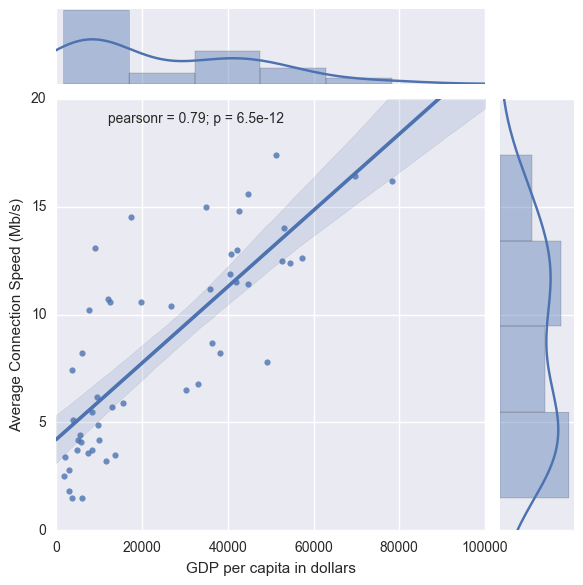

In [29]:
# Speed vs GDP per capita linear regression

sns.set(style="darkgrid", color_codes=True)

g = sns.jointplot("GDP per capita in dollars", "Average Connection Speed (Mb/s)", data=internet, kind="reg", order = 1, 
                  xlim = (0, 100000), ylim = (0, 20), size=6)

As expected, the regression shows a positive relationship between speed and GDP per capita. In addition, Pearson's R is 0.79, which suggests a strong-medium correlation between the two variables. Since p-value is approximately 0, we can also reject the hypothesis that β1=0, and conclude that the speed variable is statistically significant and this model has some use. Both variables, however, do not appear to be normally distributed. In addition, the 95% confidence interval is much wider at greater internet speeds, meaning this relationship may not be strong for countries with very high speeds.

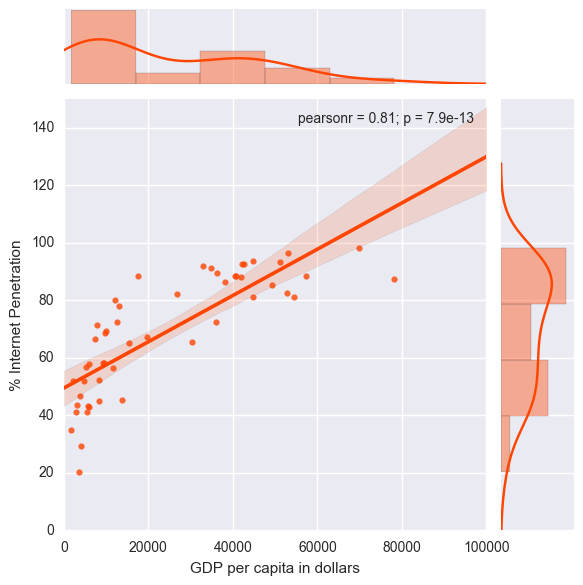

In [30]:
# Access vs GDP per capita linear regression

sns.set(style="darkgrid", color_codes=True)

g = sns.jointplot("GDP per capita in dollars", "% Internet Penetration", data=internet, kind="reg", order = 1, 
                  xlim = (0, 100000), ylim = (0, 150), color="orangered", size=6)

Similarly, the regression for access and GDP per capita shows a positive relationship. The Pearson's R is higher at 0.81, which suggests a stronger correlation between the two variables. Since p-value is also approximately 0, we can  reject the hypothesis that β1=0, and conclude that the access variable is statistically significant. Moreover, the 95% confidence interval is also quite wide at higher % penetration levels, implying the relationship may not be as meaningful with countries that have high accessibility. The internet access data does not seem to be normally distributed either. But both datasets seem close enough though, so we will not do any additional transformation to normalize the data.

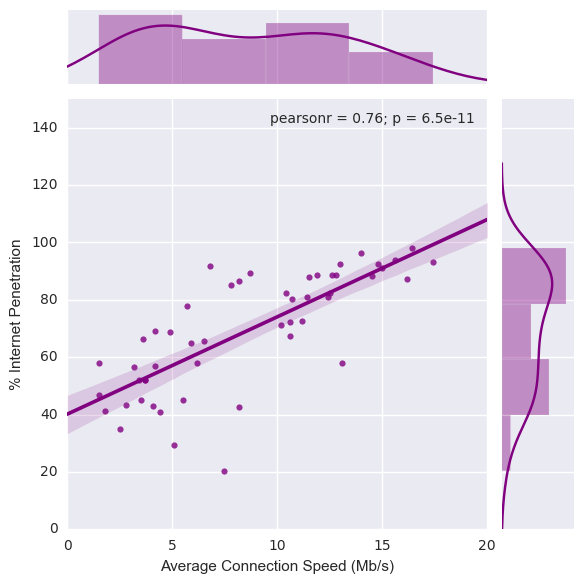

In [255]:
# Access vs speed linear regression

sns.set(style="darkgrid", color_codes=True)

g = sns.jointplot("Average Connection Speed (Mb/s)", "% Internet Penetration", data=internet, kind="reg", order = 1, 
                xlim = (0, 20), ylim = (0,150), color="purple", size=6)

Unfortuntely, it does appear that there will be significant multicollinearity in our final regression. There is a strong-medium positive relationship between internet speed and access, which is not surprising as countries with greater usuage of the internet will also likely demand faster internet speed (or the other way around, higher internet speed may encourage greater usage). This means that the R-squared value for our final regression could be inflated.

**KDE plots**

A KDE plot is a good way to get a clearer look at how the data is distributed. This is important since our jointplots showed that our datasets are not normally distributed. 

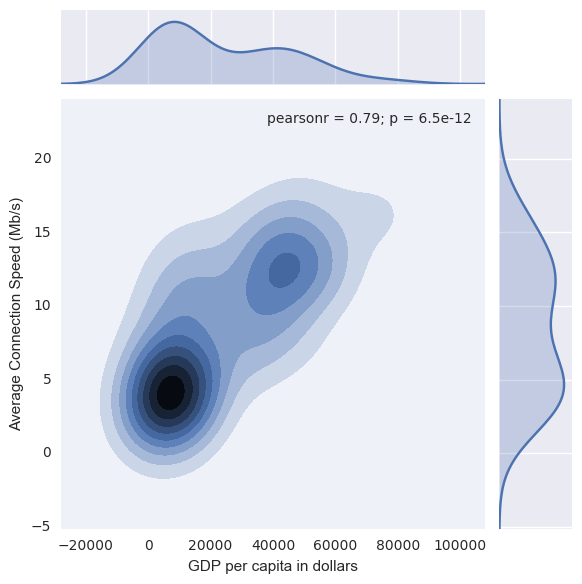

In [256]:
# KDE plot for speed vs gdp per capita
sns.jointplot(x="GDP per capita in dollars", y="Average Connection Speed (Mb/s)", data=internet, kind="kde")

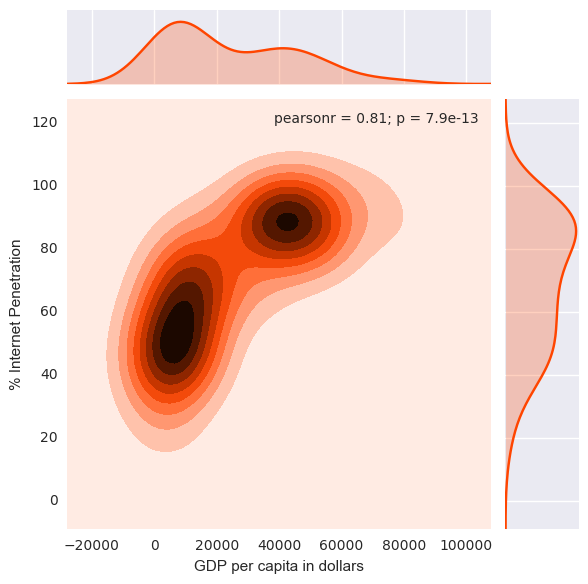

In [257]:
# KDE plot for access vs gdp per capita
sns.jointplot(x="GDP per capita in dollars", y="% Internet Penetration", data=internet, kind="kde", color='orangered')

Both KDE plots showed a similar pattern; our data points have two clusters near 10,000 and 60,000 GDP per capita. This caused the two dark areas in our KDE plots. Perhaps, there is a significant barrier that countries have to jump from low speed/access to high speed/access, and that only richer countries can get above the 10 (Mb/s) and 80% access range. It could also be the other way; perhaps countries that have the technology to support a fast and widespread network are also the countries with enough resources to achieve a higher GDP per capita. In addition, all of our variables seem to have bimodal distributions.

# Part III: Estimating GDP per Capita with a multiple variable regression

In [31]:
# Defining X and Y for the regression
X = internet[['Average Connection Speed (Mb/s)', '% Internet Penetration']]
Y = internet['GDP per capita in dollars']

# Fitting a OLS model with intercept on Speed and Access
X = sm.add_constant(X)
reg = sm.OLS(Y, X).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     GDP per capita in dollars   R-squared:                       0.723
Model:                                   OLS   Adj. R-squared:                  0.711
Method:                        Least Squares   F-statistic:                     62.54
Date:                       Fri, 12 May 2017   Prob (F-statistic):           4.29e-14
Time:                               00:07:01   Log-Likelihood:                -545.51
No. Observations:                         51   AIC:                             1097.
Df Residuals:                             48   BIC:                             1103.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -2.549e+04   5770.191     -4.417      0.000   -3.71e+04   -1.39e+04
Average Connection Speed (Mb/s)  1831.6659    525.465      3.486      0.001     775.147    2888.185
% Internet Penetration            495.4706    118.470      4.182      0.000     257.270     733.672
==============================================================================
Omnibus:                        2.146   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                1.384
Skew:                          -0.005   Prob(JB):                        0.501
Kurtosis:                       3.807   Cond. No.                         271.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$GDP per capita = -2.549e^4 + 1831.6659(Speed) + 495.4706(Access)$

The regression has a decent R-squared, at 72.3% (but a significant amount of correlation likely came from the relationship between speed and access). In addition, the p-value for the F-test is near 0, which means that this model does have some use. Lastly, the standard errors are quite large, which means that our model may not be very accurate. 

**Using + visualizing the regression**

We want to test out the model on United States and two countries with very little/inaccurate GDP data (Georgia and North Korea). We also want to plot out the regression just to make it easier to visualize.

[Georgia Speed and Access](http://www.internetworldstats.com/asia/ge.htm)<br>[North Korea Speed](http://www.upi.com/Top_News/World-News/2016/06/08/North-Korea-Internet-speed-among-slowest-in-the-world/5111465406046/) <br> [North Korea Access](http://www.internetworldstats.com/asia/kp.htm)

In [32]:
# Using the regression to predict GDP per capita of Georgia
# Georgia speed is 1.6875 Mb/s and access is 48.9%. WEO data for gdp is missing
# North Korea speed is 0.2500 Mb/s and access is 0.1%

# Defining the regression function
def z_func(x,y):
    return (1831.6659*x + 495.4706*y - 2.549*10**4)   

print('Georgia //', 'Regression GDP per capita: $', z_func(1.6875, 48.9), '| Older IMF GDP per capita: $', 3720)
print('North Korea //', 'Regression GDP per capita: $', z_func(0.2500, 0.1), '| Predicted GDP per capita: $', 583)
print('US //', 'Regression GDP per capita: $', z_func(12.6, 88.5), '| WEO GDP per capita: $', 57220.196)


Georgia // Regression GDP per capita: $ 1829.448546249998 | Older IMF GDP per capita: $ 3720
North Korea // Regression GDP per capita: $ -24982.536465 | Predicted GDP per capita: $ 583
US // Regression GDP per capita: $ 41438.138439999995 | WEO GDP per capita: $ 57220.196


**Plotting the regression**

In [33]:
# Defining the variables for plotting 
x = arange(0,20,1) # Setting the input X variables/axis
y = arange(0,100,1) # Setting the input Y variables/axis
X,Y = meshgrid(x, y) # grid of point
Z = z_func(X, Y) # Setting Z as a function of X and Y using the regression

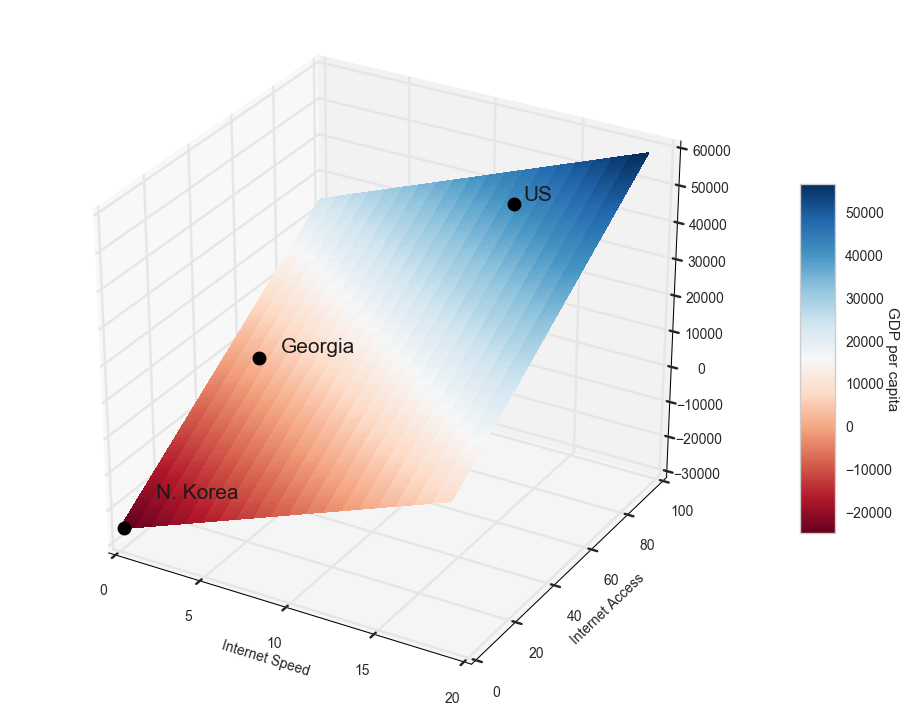

In [39]:
# Plotting the 3d figure 
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,9))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.set_xlabel('Internet Speed', fontsize=10)
ax.set_ylabel('Internet Access', fontsize=10)

# Creating and customizing the colour bar
cbar= fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.set_label('GDP per capita', rotation=270)

# Plotting the points 
ax.plot([12.6], [88.5], [41438], 'o', color='black', markersize=10)
ax.text(13, 90, 42000, "US", color='k', fontsize=15)
ax.plot([2.305], [48.9], [2961], 'o', color='black', markersize=10)
ax.text(3, 54, 3000, "Georgia", color='k', fontsize=15)
ax.plot([0.2500], [0.1], [-24982], 'o', color='black', markersize=10)
ax.text(2, 2, -15000, "N. Korea", color='k', fontsize=15)

plt.show()

## Conclusion

By looking at the relationships between internet speed/access to GDP per capita, we were able to determine a statistically significant positive relationship between the variables. We saw from the scatterplots that internet access seems to play a bigger role in accelerating GDP per capita for poorer countries, but reaches a plateau at around 80% access. Speed, on the other hand, seems to contribute to a more steady increase in GDP per capita. Both of those observations are reasonable; the avaliability of internet could be a huge initital driver for foundations like education, hence, it forms a base for greater GDP per capita. Speed, however, may continue to be relevant at higher levels since more developed countries like the US could be making use of greater internet speed to advance their growing technology sector. Our final regression placed a large emphasis on internet access as the contributing factor to high GDP per capita. From the graph above, we can see that the regression does a decent job when internet access is about 40% and higher. It, however, over "punishes" low internet access such as with North Korea, giving it a negative GDP per capita that is far below the estimate number. In fact, the model underestimates GDP per capita for all 3 of our test countries.

Overall, we believe this notebook shows that there are ways to measure GDP outside of the typical output processes. It may not be as accurate, but could be useful in some situations such as comparing US GDP with Georgia, where there is no 2016 data for Georgia. And on the regression above, we expect a rather large gap between the GDP per capita of US and Georgia.